In [43]:
# Imports
import pygame as pg
import pygame.mouse as mouse
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Models
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from random import sample
import base64

In [28]:
# Window
framerate = 120
delta_time = 1 / 120.0

columns = 20
rows = 10

cell_width = 57
cell_height = 80

width = columns * cell_width
height = rows * cell_height

#pg.init()
#surface = pg.display.set_mode((width, height))
#clock = pg.time.Clock()

In [44]:
# Sprite class
class Sprite:
	def __init__(self, x, y, img_src, w, h):
		self.x = x
		self.y = y
		self.w = w
		self.h = h
		self.tx = x - w / 2
		self.ty = y - h / 2
		self.tw = w
		self.th = h
		self.source = pg.image.load("sprites/" + img_src)
		self.image = pg.transform.scale(self.source, (w, h))
		self.angle = 0

	def set_center(self, x, y):
		self.x = x
		self.y = y
		self.tx = x - self.w / 2
		self.ty = y - self.h / 2

	def update(self):
		self.tx = self.x - self.tw / 2
		self.ty = self.y - self.th / 2

	def set_angle(self, new_angle):
		if self.angle == new_angle:
			return
		self.angle = new_angle
		rad_angle = self.angle * np.pi / 180.0
		self.image = pg.transform.scale(self.source, (self.w, self.h))
		self.image = pg.transform.rotate(self.image, - self.angle)
		if np.cos(rad_angle) * np.sin(rad_angle) >= 0:
			self.tw = np.absolute(self.w * np.cos(rad_angle) + self.h * np.sin(rad_angle))
			self.th = np.absolute(self.w * np.sin(rad_angle) + self.h * np.cos(rad_angle))
		else:
			self.tw = np.absolute(self.w * np.cos(rad_angle) - self.h * np.sin(rad_angle))
			self.th = np.absolute(self.w * np.sin(rad_angle) - self.h * np.cos(rad_angle))
		self.tx = self.x - self.tw / 2
		self.ty = self.y - self.th / 2

	def draw(self):
		surface.blit(self.image, (self.tx, self.ty))

In [45]:
# Data
nivel = random.randrange(22)
invertir = random.randrange(2)

im = Image.open("levels/nivel" + str(nivel) + ".png", 'r').convert("RGB")
pix_val = list(im.getdata())

monkey_initial_position = [2, 7]

bloons_data = []

def reset_bloons():
    global bloons_data, monkey_initial_position, im, pix_val
    bloons_data = []
    
    nivel = random.randrange(22)
    invertir = random.randrange(2)
    im = Image.open("levels/nivel" + str(nivel) + ".png", 'r').convert("RGB")
    pix_val = list(im.getdata())
    
    bloons_added = 0
    for i in range(columns):
        bloons_data.append([])
    
        if not invertir:
            for j in range(rows):
                if pix_val[j*columns + i] == (0,0,0):
                    bloons_data[i].append(1)
                    bloons_added += 1
                elif pix_val[j*columns + i] == (255,255,255):
                    bloons_data[i].append(0)

                if pix_val[j*columns + i] == (255,0,0):
                    monkey_initial_position = [i, j]    # x and y positions (on the grid)
                    bloons_data[i].append(0)
        else:
            k = (columns-i-1)
            for j in range(rows):
                if pix_val[j*columns + k] == (0,0,0):
                    bloons_data[i].append(1)
                    bloons_added += 1
                elif pix_val[j*columns + k] == (255,255,255):
                    bloons_data[i].append(0)

                if pix_val[j*columns + k] == (255,0,0):
                    monkey_initial_position = [i, j]    # x and y positions (on the grid)
                    bloons_data[i].append(0)
                    
    return bloons_added

reset_bloons()

18

In [46]:
# Sprites
background_sprite = None
bloon_img = None
bloon_sprites = None
monkey_sprite = None
arm_sprite = None
dart_sprite = None

def reset_sprites():
	global background_sprite, bloon_img, bloon_sprites, monkey_sprite, arm_sprite, dart_sprite, bloons_data
	background_sprite = Sprite(width / 2, height / 2, "background.png", width, height)
	bloon_img = "red_bloon", "green_bloon", "blue_bloon", "yellow_bloon"

	bloon_sprites = []
	for i in range(columns):
		bloon_sprites.append([])
		for j in range(rows):
			if bloons_data[i][j] == 1:
				bloon_sprites[i].append(Sprite((i + 0.5) * cell_width, (j + 0.5) * cell_height, bloon_img[random.randrange(4)] + ".png", cell_width, cell_height))
				#bloon_sprites[i][j].set_angle(random.randrange(21) - 10)
			else:
				bloon_sprites[i].append(None)

	monkey_sprite = Sprite(monkey_initial_position[0] * cell_width + cell_width / 2, monkey_initial_position[1] * cell_height + cell_height / 2, "monkey.png", 148, 116)
	arm_sprite = Sprite(0, 0, "monkey_arm_centered.png", 196, 196)
	arm_sprite.set_center(monkey_sprite.x - 25, monkey_sprite.y - 5)
	dart_sprite = Sprite(0, 0, "dart.png", 136, 136)

reset_sprites()

In [47]:
# Draw function
def draw():
	background_sprite.draw()
	for i in range(columns):
		for j in range(rows):
			if bloon_sprites[i][j] != None:
				bloon_sprites[i][j].draw()
	monkey_sprite.draw()
	arm_sprite.draw()
	dart_sprite.draw()
	pg.display.update()

In [48]:
# Dart
flying = False
dart_speed = 2400
dart_velocity = [0, 0]
dart_gravity = 3840

In [34]:
# Input
mouse_angle = 0
right_click = False

In [83]:
# Env
observation_space = columns * rows + 3
action_space = 72

env_delta_time = 1 / 60.0
darts_left = 15
bloons_left = 0

def step(action_angle):
	global darts_left, bloons_left
	darts_left -= 1
	reward = -2

	dart_velocity[0] = dart_speed * np.cos(action_angle * np.pi * 5 / 180.0)
	dart_velocity[1] = dart_speed * np.sin(action_angle * np.pi * 5 / 180.0)
	magnitude = np.sqrt(dart_velocity[0]**2 + dart_velocity[1]**2)
	dart_sprite.x = monkey_sprite.x + dart_velocity[0] / magnitude * 0.01
	dart_sprite.y = monkey_sprite.y + dart_velocity[1] / magnitude * 0.01

	while True:
		dart_velocity[1] += dart_gravity * env_delta_time
		dart_velocity_angle = math.atan2(dart_velocity[1], dart_velocity[0]) * 180 / np.pi
		dart_sprite.x += dart_velocity[0] * env_delta_time
		dart_sprite.y += dart_velocity[1] * env_delta_time
		dart_sprite.update()
		dart_sprite.set_angle(dart_velocity_angle) # evaluar

		tip = [0, 0]
		tip[0] = dart_sprite.x + dart_sprite.w / 2 * np.cos(dart_velocity_angle * np.pi / 180.0)
		tip[1] = dart_sprite.y + dart_sprite.w / 2 * np.sin(dart_velocity_angle * np.pi / 180.0)

		pop = [-1, -1]
		pop[0] = int(tip[0] / cell_width)
		pop[1] = int(tip[1] / cell_height)

		if pop[0] >= 0 and pop[0] < columns and pop[1] >= 0 and pop[1] < rows and bloons_data[pop[0]][pop[1]] == 1:
			bloons_data[pop[0]][pop[1]] = 0
			bloon_sprites[pop[0]][pop[1]] = None
			reward += 1
			bloons_left -= 1

		if dart_sprite.x > width or dart_sprite.x < 0 or dart_sprite.y > height:
			return_state = np.empty((1, observation_space), dtype=int)
			for i in range(columns):
				for j in range(rows):
					return_state[0, i * rows + j] = bloons_data[i][j]
			return_state[0, columns * rows] = monkey_initial_position[0]
			return_state[0, columns * rows + 1] = monkey_initial_position[1]
			return_state[0, columns * rows + 2] = darts_left
			done = darts_left <= 0 or bloons_left <= 0
			return return_state, reward, done

def reset():
	global darts_left, bloons_left
	darts_left = 15
	bloons_left = reset_bloons()
	reset_sprites()
	return_state = np.empty((1, rows * columns + 3), dtype=int)
	for i in range(columns):
		for j in range(rows):
			return_state[0, i * rows + j] = bloons_data[i][j]
	return_state[0, columns * rows] = monkey_initial_position[0]
	return_state[0, columns * rows + 1] = monkey_initial_position[1]
	return_state[0, columns * rows + 2] = darts_left
	return return_state

In [85]:
# Network, Buffer and Agent

aux = np.ones((observation_space,))

LEARNING_RATE = 0.0003
MEM_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.99999
EXPLORATION_MIN = 0.001

FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = T.device("cpu:0")

class Network(T.nn.Module):
    def __init__(self, input_shape, action_space):
        super().__init__()
        self.input_shape = input_shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0
        
        self.states = np.zeros((MEM_SIZE, *aux.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *aux.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=bool)
    
    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE
        
        self.states[mem_index]  = state
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_
        self.dones[mem_index] =  1 - done

        self.mem_count += 1
    
    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)
        
        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network(aux.shape, action_space)

    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return random.randrange(72)
        
        state = T.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return T.argmax(q_values).item()

    def choose_action_greedy(self, observation):
        state = T.tensor(observation).float().detach()
        state = state.to(DEVICE)
        state = state.unsqueeze(0)
        q_values = self.network(state)
        return T.argmax(q_values).item()
    
    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return
        
        states, actions, rewards, states_, dones = self.memory.sample()
        states = T.tensor(states , dtype=T.float32).to(DEVICE)
        actions = T.tensor(actions, dtype=T.long).to(DEVICE)
        rewards = T.tensor(rewards, dtype=T.float32).to(DEVICE)
        states_ = T.tensor(states_, dtype=T.float32).to(DEVICE)
        dones = T.tensor(dones, dtype=bool).to(DEVICE)
        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        q_values = self.network(states)
        predicted_value_of_now = q_values[batch_indices, actions]

        next_q_values = self.network(states_)
        predicted_value_of_future = T.max(next_q_values, dim=1)[0]
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate
    
    def load_data(self, path):
        self.network = Network(aux.shape, action_space)
        self.network.load_state_dict(T.load(path))
        self.network.eval()

In [86]:
# Creation of new agent
agent = DQN_Solver()

1 - Average -15.0 - Best -15 - Last -15 - Epsilon 1.0
3 - Average -15.333333333333334 - Best -9 - Last -9 - Epsilon 1.0
9 - Average -18.22222222222222 - Best -8 - Last -8 - Epsilon 0.9992802555403735
11 - Average -16.636363636363637 - Best 3 - Last 3 - Epsilon 0.998980514928347
100 - Average -19.84 - Best 3 - Last -18 - Epsilon 0.9857326848362341
103 - Average -19.553398058252426 - Best 7 - Last 7 - Epsilon 0.9853877370411865
200 - Average -19.395 - Best 7 - Last -1 - Epsilon 0.9711540752969126
256 - Average -18.99609375 - Best 14 - Last 14 - Epsilon 0.9630690293826575
296 - Average -18.783783783783782 - Best 17 - Last 17 - Epsilon 0.9573078871109445
300 - Average -18.84 - Best 17 - Last -30 - Epsilon 0.956733671789422
400 - Average -18.6975 - Best 17 - Last -25 - Epsilon 0.9425556693304202
500 - Average -18.37 - Best 17 - Last -1 - Epsilon 0.9285970591230492
600 - Average -18.258333333333333 - Best 17 - Last -17 - Epsilon 0.9148085732081574
700 - Average -18.11285714285714 - Best 17 -

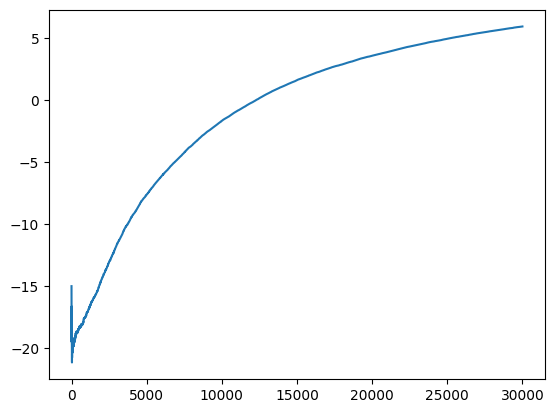

In [63]:
# Learning

EPISODES = 30000

best_reward = -30
average_reward = 0

episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = reset()
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        action = agent.choose_action(state)
        state_, reward, done = step(action)
        state_ = np.reshape(state_, [1, observation_space])
        agent.memory.add(state, action, reward, state_, done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward or i % 100 == 0:
                if score > best_reward:
                    best_reward = score
                print("{} - Average {} - Best {} - Last {} - Epsilon {}".format(i, (average_reward + score)/i, best_reward, score, agent.returning_epsilon()))    
                
            average_reward += score 
            episode_number.append(i)
            average_reward_number.append(average_reward/i)
            break
        
plt.plot(episode_number, average_reward_number)
plt.show()

In [89]:
GAMES = 50

pg.init()
surface = pg.display.set_mode((width, height))
clock = pg.time.Clock()
run = True
env_delta_time = 1 / 120.0

for i in range(1, GAMES):
    state = reset()
    state = np.reshape(state, [1, observation_space])
    score = 0
    
    action = agent.choose_action_greedy(state)
    
    dart_velocity[0] = dart_speed * np.cos(action * np.pi * 5 / 180.0)
    dart_velocity[1] = dart_speed * np.sin(action * np.pi * 5 / 180.0)
    magnitude = np.sqrt(dart_velocity[0]**2 + dart_velocity[1]**2)
    dart_sprite.x = monkey_sprite.x + dart_velocity[0] / magnitude * 0.01
    dart_sprite.y = monkey_sprite.y + dart_velocity[1] / magnitude * 0.01

    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        dart_velocity[1] += dart_gravity * env_delta_time
        dart_velocity_angle = math.atan2(dart_velocity[1], dart_velocity[0]) * 180 / np.pi
        dart_sprite.x += dart_velocity[0] * env_delta_time
        dart_sprite.y += dart_velocity[1] * env_delta_time
        dart_sprite.update()
        dart_sprite.set_angle(dart_velocity_angle) # evaluar

        tip = [0, 0]
        tip[0] = dart_sprite.x + dart_sprite.w / 2 * np.cos(dart_velocity_angle * np.pi / 180.0)
        tip[1] = dart_sprite.y + dart_sprite.w / 2 * np.sin(dart_velocity_angle * np.pi / 180.0)

        pop = [-1, -1]
        pop[0] = int(tip[0] / cell_width)
        pop[1] = int(tip[1] / cell_height)

        if pop[0] >= 0 and pop[0] < columns and pop[1] >= 0 and pop[1] < rows and bloons_data[pop[0]][pop[1]] == 1:
            bloons_data[pop[0]][pop[1]] = 0
            bloon_sprites[pop[0]][pop[1]] = None
            bloons_left -= 1

        if dart_sprite.x > width or dart_sprite.x < 0 or dart_sprite.y > height:
            darts_left -= 1
            return_state = np.empty((1, observation_space), dtype=int)
            for i in range(columns):
                for j in range(rows):
                    return_state[0, i * rows + j] = bloons_data[i][j]
            return_state[0, columns * rows] = monkey_initial_position[0]
            return_state[0, columns * rows + 1] = monkey_initial_position[1]
            return_state[0, columns * rows + 2] = darts_left
            
            if darts_left <= 0 or bloons_left <= 0:
                state = reset()
            else:
                state = return_state
            
            action = agent.choose_action_greedy(state)
            print(action)
            dart_velocity[0] = dart_speed * np.cos(action * np.pi * 5 / 180.0)
            dart_velocity[1] = dart_speed * np.sin(action * np.pi * 5 / 180.0)
            magnitude = np.sqrt(dart_velocity[0]**2 + dart_velocity[1]**2)
            dart_sprite.x = monkey_sprite.x + dart_velocity[0] / magnitude * 0.01
            dart_sprite.y = monkey_sprite.y + dart_velocity[1] / magnitude * 0.01
            
        draw()
        clock.tick_busy_loop(framerate)
        pg.display.set_caption("Bloons AI - FPS: " + str(int(clock.get_fps())))

pg.quit()
        

38
70
71
3
5
69
2
7
0
64
58
52
56
53
68
62
60
50
54
54
54
54
66
66
1
6
5
5
5
5
5
1
1
1
17
0
70
70
54
43
45
40
41
46
64
61
47
44
49
59
58
50
68
62
54
56
64
64
64
64
64
64
64
64
64
64
64
65
68
62
56
65
62
66
64
56
68
56
62
60
66
57
65
56
55
61
58
70
68
59
54
65
64
66
66
66
66
66
46
40
54
52
52
52
52
52
52
52
52
52
52
37
37
45
43
41
46
64
68
70
66
61
65
71
2
63
59
57
0
53
52
47
50
39
38
45
54
49
42
56
56
37
37
37
45
43
41
46
7
12
29
25
32
2
34
22
4
14
9
24
31
5
27
9
54
68
56
62
60
66
57
65
71
3
5
69
2
7
0
64
61
44
47
59
49
58
50
1
6
5
5
5
5
5
1
1
1
17
0
70
70
54
43
45
40
41
46
64
61
44
47
59
49
58
50
65
68
62
56
27
54
9
63
58
43
46
40
60
59
45
57
43
40
46
52
37
37
37
37
37
37
37
37
37
37
37
37
37
37
35
65
62
66
64
56
68
56
62
60
66
57
65
64
68
70
66
61
65
71
2
63
59
57
0
45
43
41
46
37
37
37
37
37
37
37
37
37
37
37
37
37
37
35
64
58
52
56
53
68
62
60
50
54
54
54
54
66
66
7
12
29
25
32
2
34
22
4
14
9
24
31
5
46
40
54
52
52
52
52
52
52
52
52
52
52
37
37
46
40
54
52
52
52
52
52
52
52
52
52
5

In [64]:
#guardar agente
T.save(agent.network.state_dict(), "Network.zip")

In [87]:
#recuperar agente
agent.load_data("Network.zip")

In [41]:
## Game
#pg.init()
#surface = pg.display.set_mode((width, height))
#clock = pg.time.Clock()
#
#reset_bloons()
#
#run = True
#while run:
#	for event in pg.event.get():
#		if event.type == pg.QUIT:
#			run = False
#
#	#keys = pg.key.get_pressed()
#	[mouse_x, mouse_y] = mouse.get_pos()
#
#	#left_onpress = not left_click
#	left_click = mouse.get_pressed(3)[0]
#	if left_click and not flying:
#		flying = True
#		dart_velocity[0] = dart_speed * np.cos(mouse_angle * np.pi / 180.0)
#		dart_velocity[1] = dart_speed * np.sin(mouse_angle * np.pi / 180.0)
#		magnitude = np.sqrt(dart_velocity[0]**2 + dart_velocity[1]**2)
#		dart_sprite.x = monkey_sprite.x + dart_velocity[0] / magnitude * 0.01
#		dart_sprite.y = monkey_sprite.y + dart_velocity[1] / magnitude * 0.01
#		dart_sprite.update()
#
#	#left_onpress = left_onpress and left_click
#	right_click = mouse.get_pressed(3)[2]
#	#if right_click:
#	#	flying = False
#
#	#if (left_click or right_click) and search_state[0] == 2:
#	#	search_state[0] = 0
#	#	state = "Idle"
#	#	state_color[0] = white
#	#	state_text[0] = font.render(state, True, state_color[0], None)
#
#	#check_button_hovers(mouse_x, mouse_y, left_click, left_onpress)
#
#	mouse_angle = math.atan2(mouse_y - monkey_sprite.y, mouse_x - monkey_sprite.x) * 180.0 / np.pi
#
#	if flying:
#		arm_sprite.set_angle(mouse_angle)
#	else:
#		arm_sprite.set_angle(mouse_angle + 60)
#
#	if not flying:
#		arm_length = 30
#		dart_sprite.x = arm_sprite.x + arm_length * np.cos(arm_sprite.angle * np.pi / 180.0)
#		dart_sprite.y = arm_sprite.y + arm_length * np.sin(arm_sprite.angle * np.pi / 180.0)
#		dart_sprite.update()
#		dart_sprite.set_angle(mouse_angle)
#	else:
#		#dart_velocity[0] -= (dart_velocity[0] * dart_velocity[0]) * 0.0002 * delta_time	#roze con el aire en la componente horizontal de la velocidad
#		dart_velocity[1] += dart_gravity * delta_time
#		dart_velocity_angle = math.atan2(dart_velocity[1], dart_velocity[0]) * 180 / np.pi
#		dart_sprite.x += dart_velocity[0] * delta_time
#		dart_sprite.y += dart_velocity[1] * delta_time
#		dart_sprite.update()
#		dart_sprite.set_angle(dart_velocity_angle)
#
#		tip = [0, 0]
#		tip[0] = dart_sprite.x + dart_sprite.w / 2 * np.cos(dart_velocity_angle * np.pi / 180.0)
#		tip[1] = dart_sprite.y + dart_sprite.w / 2 * np.sin(dart_velocity_angle * np.pi / 180.0)
#
#		pop = [-1, -1]
#		pop[0] = int(tip[0] / cell_width)
#		pop[1] = int(tip[1] / cell_height)
#
#		if pop[0] >= 0 and pop[0] < columns and pop[1] >= 0 and pop[1] < rows and bloons_data[pop[0]][pop[1]] == 1:
#			bloons_data[pop[0]][pop[1]] = 0
#			bloon_sprites[pop[0]][pop[1]] = None
#
#	if dart_sprite.x > width or dart_sprite.y > height:
#		flying = False
#
#	draw()
#	clock.tick_busy_loop(framerate)
#	pg.display.set_caption("Bloons AI - FPS: " + str(int(clock.get_fps())))
#
#pg.quit()

KeyboardInterrupt: 